In [1]:
import tensorflow as tf
from sklearn.utils import shuffle
import tifffile as tiff
from tensorflow import keras as K
import tensorflow.keras.layers as L
import numpy as np
import pandas as pd
import cv2
from tqdm import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as Kb
from collections import Counter
from tensorflow.keras.activations import relu,softmax
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
# from keras_bert import get_custom_objects
import matplotlib.pyplot as plt
from vit_keras import vit,utils, visualize
# from keras_unet_collection._model_transunet_2d import *
# from keras_unet_collection.transformer_layers import *
import efficientnet.keras as efn


2022-03-24 16:27:48.023694: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
inputShape = (224,224,3)
# inputShape = (380,380,3)
inputShapeLSTM = (4,1000)
TIME_STEPS = 4
SINGLE_ATTENTION_VECTOR = False

# **Unchanged Function**

In [3]:
def BN_LeakyReLU(input):
    norm = BatchNormalization(axis=-1)(input)
    output = LeakyReLU(alpha=0.2)(norm)
    
    return output


def MDCN(input_layers, n_filters): 
    '''
    Skip connection is added.
    '''
    # stream_left
    conv_left = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 4, kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l2(0.0001))(input_layers)
    conv_left = BN_LeakyReLU(conv_left)
    # stream_middle_up
    conv_middle_1 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 3, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(input_layers)
    conv_middle_1 = BN_LeakyReLU(conv_middle_1)
    # stream_right_up
    conv_right_1 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(input_layers)
    conv_right_1 = BN_LeakyReLU(conv_right_1)
    conv_right_2 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(conv_right_1)
    conv_right_2 = BN_LeakyReLU(conv_right_2)
    
    # stream_sum_1
    sum_1 = add([conv_middle_1, conv_right_2])
    
    # stream_middle_down
    conv_middle_2 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 3, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(sum_1)
    conv_middle_2 = BN_LeakyReLU(conv_middle_2)
    # stream_right_down
    conv_right_3 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(sum_1)
    conv_right_3 = BN_LeakyReLU(conv_right_3)
    conv_right_4 = Conv2D(n_filters, (3, 3), padding='same', dilation_rate = 2, kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(0.0001))(conv_right_3)
    conv_right_4 = BN_LeakyReLU(conv_right_4)
    # print(input_layers.shape,conv_left.shape,conv_middle_2.shape,conv_right_4.shape) 
    # stream_sum_2
    # sum_2 = add([conv_left, conv_middle_2, conv_right_4])
    sum_2 = add([conv_left, conv_middle_2, conv_right_4,input_layers])
    
    return sum_2
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = L.Permute((2, 1))(inputs)
    a = L.Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = L.Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = L.Permute((2, 1), name='attention_vec')(a)
    # print(inputs.shape,a_probs.shape)
    output_attention_mul = L.Multiply()([inputs, a_probs])
    return output_attention_mul

In [4]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, cohen_kappa_score
import matplotlib.pyplot as pl
def get_OA(cm):
    
    total = cm.sum()
    
    diag_arr = np.diagonal(cm, offset=0)
    
    correct = diag_arr.sum()
    
    OA = (correct/total) * 100
    
    return OA
def getOAThreshold(Y_pred,threshold=0.8):
    tmp = []
    for i in range(len(Y_pred)):
        if Y_pred[i][0] > threshold:
            tmp.append(0)
        else:
            tmp.append(1)
    return tmp
def get_cm_oa_kappa(Y_test, Y_pred):
    
    # Y_pred = np.argmax(Y_pred, axis=1)
    
    Y_test = Y_test.tolist()
    # Y_pred = Y_pred.tolist()
   
    cm = confusion_matrix(Y_test,Y_pred)
    
    oa = get_OA(cm)
    
    kappa = cohen_kappa_score(Y_test,Y_pred)
    
    # print(cm)
    
    return cm, oa, kappa
def plot_matrix(y_test, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
    Y_pred = np.argmax(y_pred, axis=1)
    
    y_true = y_test.tolist()
    Y_pred = Y_pred.tolist()
    # 利用sklearn中的函数生成混淆矩阵并归一化
    cm = confusion_matrix(y_true, Y_pred)  # 生成混淆矩阵 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化

    # 画图，如果希望改变颜色风格，可以改变此部分的cmap=pl.get_cmap('Blues')处
    pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'))
    pl.colorbar()  # 绘制图例
    pl.title(title, fontsize=15,fontfamily='SimHei')
    # 图像标题
    if title is not None:
        pl.title(title)
    # 绘制坐标
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    pl.xticks(num_local, axis_labels, rotation=45, fontsize=10)  # 将标签印在x轴坐标上， 并倾斜45度
    pl.yticks(num_local, axis_labels, fontsize=10)  # 将标签印在y轴坐标上
    pl.ylabel('True label',fontsize=12,verticalalignment='center')
    pl.xlabel('Predicted label',fontsize=12,verticalalignment='center')
    

    # 将百分比打印在相应的格子内，大于thresh的用白字，小于的用黑字
    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                pl.text(j, i, format(int(cm[i][j] * 100), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")  # 如果要更改颜色风格，需要同时更改此行
    # 显示
    # pl.figure(dpi=1000) 
    # pl.savefig('/content/gdrive/MyDrive/UV3/resultImage/MVRANcm_total.png',dpi=1000,bbox_inches = 'tight')
    
    pl.show()
def transpose(input):
    
    x=tf.transpose(input, perm=[0, 2, 1])
    return x

def expand_dims1(input):
    x=tf.expand_dims(input, axis=1)
    return x

def expand_dims2(input):
    x=tf.expand_dims(input, axis=-1)
    return x

def matmul(input):
    """input must be a  list"""
    return tf.matmul(input[0],input[1])

def gcnet_layer(inputs):
    
    x=inputs
    bs, h, w, c = x.get_shape().as_list()
    input_x = x
    input_x = Reshape((-1, c))(input_x)  # [N, H*W, C]
    input_x = Lambda(transpose)(input_x)  # [N,C,H*W]
    input_x = Lambda(expand_dims1)(input_x)

    context_mask = Conv2D(filters=1, kernel_size=(1, 1))(x)
    context_mask = Reshape((-1, 1))(context_mask)
    context_mask = softmax(context_mask, axis=1)  # [N, H*W, 1]
    context_mask = Lambda(transpose)(context_mask)
    context_mask = Lambda(expand_dims2)(context_mask)

    context = Lambda(matmul)([input_x,context_mask])  # [N,1,c,1]
    context = Reshape((1, 1, c))(context)

    context_transform = Conv2D(int(c/8), (1, 1))(context)
    context_transform = LayerNormalization()(context_transform)
    context_transform = relu(context_transform)
    context_transform = Conv2D(c, (1, 1))(context_transform)

    x= add([x,context_transform])

    return x

# **Model Traning**

###  **一维融合**

In [11]:
def MDCNN_1D(input_layer):
    n_filters = 64

    # input_layer = L.Input(shape=inputShape)
    conv_1 = Conv2D(2*n_filters, (7, 7), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(input_layer)
    conv_2 = BN_LeakyReLU(conv_1)
    # print('conv_2: {}'.format(conv_2.shape))
    block_1 = MDCN(conv_2, 2*n_filters)  # 128
    # print('block_1: {}'.format(block_1.shape))
    block_2 = MDCN(block_1, 2*n_filters)  # 128
    # print('block_2: {}'.format(block_2.shape))
    conv_3 = Conv2D(4*n_filters, (7, 7), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(block_2)
    # conv_3 = Conv2D(4*n_filters, (3, 3), padding='valid', strides=(1, 1), kernel_initializer='he_normal',
    #                 kernel_regularizer=regularizers.l2(0.0001))(conv_3 )
    conv_3 = BN_LeakyReLU(conv_3)
    # print('conv_3: {}'.format(conv_3.shape)
    block_3 = MDCN(conv_3, 4*n_filters)  # 256
    # print('block_3: {}'.format(block_3.shape))
    block_4 = MDCN(block_3, 4*n_filters)  # 256
    # print('block_4: {}'.format(block_4.shape))
    conv_4 = Conv2D(8*n_filters, (3,3), padding='valid', strides=(1, 1), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(block_4)  # 512
    conv_4 = Conv2D(8*n_filters, (3, 3), padding='valid', strides=(1, 1), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv_4)  # 512
    conv_4 = BN_LeakyReLU(conv_4)
    # print('conv_4: {}'.format(conv_4.shape))

    block_5 = MDCN(conv_4, 8*n_filters)  # 512
    # # print('block_5: {}'.format(block_5.shape))
    conv_5 = Conv2D(3, (3, 3), padding='same', strides=(1, 1), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(block_5)  # 512 
    block_6 = MDCN(conv_5, 3)  # 3
    # print('block_6: {}'.format(block_6.shape))
    # print(block_6)
    
    # VIT = vit.vit_b16option(
    #     image_size=48,
    #     activation='sigmoid',
    #     pretrained=False,
    #     include_top=True,
    #     pretrained_top=False,
    #     classes=512
    # ) 
    VIT = vit.vit_b16option(
        image_size=48,
        activation='sigmoid',
        pretrained=False,
        include_top=True,
        pretrained_top=False,
        classes=512
    ) 
    output = VIT(block_6)

    return output

In [6]:

def trainFusion_1D(X,Y,valX,valY):
    mmodel = FusionModel_1D()
    optm = K.optimizers.Adam(lr = 1e-4)
    # optm = K.optimizers.Adam(lr = 1e-4)
    mmodel.compile(optimizer = optm, loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])
    model_checkpoint = ModelCheckpoint('/home/chen/UV3/weightManager/Fusion_1D.h5', monitor='val_acc', verbose=0, 
                                        save_best_only=True, save_weights_only=False,period=1)

    early_stopping =EarlyStopping(monitor='val_acc', patience=20)
    input_y = to_categorical(Y)
    # print(input_y.shape)
    input_x = [
        X[:,0,:,:,:],
        X[:,1,:,:,:],
        X[:,2,:,:,:],
        X[:,3,:,:,:],
        X[:,4,:,:,:],        
    ]
    input_val_y = to_categorical(valY)
    input_val_x = [
        valX[:,0,:,:,:],
        valX[:,1,:,:,:],
        valX[:,2,:,:,:],
        valX[:,3,:,:,:],
        valX[:,4,:,:,:],        首页
    ]
    print(input_y.shape,input_val_y.shape)

    # history=mmodel.fit(x=input_x,y=input_y,batch_size=25,epochs=200,shuffle=True,validation_data=(input_val_x, input_val_y),
    #             callbacks=[model_checkpoint])
    history=mmodel.fit(x=input_x,y=input_y,batch_size=6,epochs=100,shuffle=True,validation_data=(input_val_x, input_val_y),
                callbacks=[model_checkpoint,early_stopping])
    return historye([embedding0,embedding90,embedding180,embedding270])
    CNN_embedding = tf.stack([embedding0,embedding90,embedding180,embedding270], 1) 
    # print(CNN_embedding.shape)
    # CNN_embedding = tf.expand_dims(CNN_embedding, 0)
    LSTM_output = L.Bidirectional(L.LSTM(units=64,return_sequences=True),input_shape=inputShapeLSTM)(CNN_embedding)
    attention_mul = attention_3d_block(LSTM_output)
    # print(attention_mul.shape)
    LSTM_vector = L.Flatten(input_shape = (4,128))(attention_mul)
    output = LSTM_vector
    return output

In [7]:
def FusionModel_1D():
    inputUV = L.Input(shape=inputShape)
    input0 = L.Input(shape=inputShape)
    input90 = L.Input(shape=inputShape)
    input180 = L.Input(shape=inputShape)
    input270 = L.Input(shape=inputShape)

    #Two branch
    left = MDCNN_1D(inputUV)
    right = MVRAN_1D(input0,input90,input180,input270)
    
    ######################1-D Fusion#########################
    StackFeature = tf.stack([left,right],2) 
    print(StackFeature.shape)
    StackFeature= tf.expand_dims(StackFeature,axis=1)
    print(StackFeature.shape)
    conv_1 = Conv2D(256, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(StackFeature)
    print(conv_1.shape)
    leftWeight = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(conv_1)
    rightWeight = Conv2D(1, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(conv_1)
    leftWeight = tf.squeeze(leftWeight,axis=[1,3])
    rightWeight = tf.squeeze(rightWeight,axis=[1,3])
    concatLeft = L.Multiply()([left, leftWeight])
    concatRight = L.Multiply()([right, rightWeight])
    print(concatLeft.shape)
    concat_2 = tf.stack([concatLeft,concatRight], 2)
    concat_2 = tf.expand_dims(concat_2,axis=1)
    conv_2 = Conv2D(64, (1, 1), padding='same',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(concat_2)
    flat = L.Flatten()(conv_2)

    dense1 = L.Dense(128, kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.0001))(flat)
    dense2 = L.Dropout(0.5)(dense1)
    output = L.Dense(2, activation='softmax')(dense2)
    # output = StackFeature
    FModel = Model(inputs=[inputUV,input0,input90,input180,input270],outputs = output)
    return FModel

In [8]:
 #模型训练
def trainFusion_1D(X,Y,valX,valY):
    mmodel = FusionModel_1D()
    optm = K.optimizers.Adam(lr = 1e-4)
    # optm = K.optimizers.Adam(lr = 1e-4)
    mmodel.compile(optimizer = optm, loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['acc'])
    model_checkpoint = ModelCheckpoint('/home/chen/UV3/weightManager/Fusion_1D.h5', monitor='val_acc', verbose=0, 
                                        save_best_only=True, save_weights_only=False,period=1)

    early_stopping =EarlyStopping(monitor='val_acc', patience=20)
    input_y = to_categorical(Y)
    # print(input_y.shape)
    input_x = [
        X[:,0,:,:,:],
        X[:,1,:,:,:],
        X[:,2,:,:,:],
        X[:,3,:,:,:],
        X[:,4,:,:,:],        
    ]
    input_val_y = to_categorical(valY)
    input_val_x = [
        valX[:,0,:,:,:],
        valX[:,1,:,:,:],
        valX[:,2,:,:,:],
        valX[:,3,:,:,:],
        valX[:,4,:,:,:],        首页
    ]
    print(input_y.shape,input_val_y.shape)

    # history=mmodel.fit(x=input_x,y=input_y,batch_size=25,epochs=200,shuffle=True,validation_data=(input_val_x, input_val_y),
    #             callbacks=[model_checkpoint])
    history=mmodel.fit(x=input_x,y=input_y,batch_size=6,epochs=100,shuffle=True,validation_data=(input_val_x, input_val_y),
                callbacks=[model_checkpoint,early_stopping])
    return history

In [9]:
train_X = np.load('/home/chen/UV3/Dataset/Total/train_X.npy')
train_Y = np.load('/home/chen/UV3/Dataset/Total/train_Y.npy')
val_X = np.load('/home/chen/UV3/Dataset/Total/test_X.npy')
val_Y = np.load('/home/chen/UV3/Dataset/Total/test_Y.npy')
# trainFusion_1D(train_X,train_Y,val_X,val_Y)

In [ ]:
# trainFusion_1D(train_X,train_Y,val_X,val_Y)

In [9]:

test_X = np.load('/home/chen/UV3/Dataset/Total/test_X.npy')
test_x = [
    test_X[:,0,:,:,:],
    test_X[:,1,:,:,:],
    test_X[:,2,:,:,:],
    test_X[:,3,:,:,:],
    test_X[:,4,:,:,:],
    ]
test_Y = np.load('/home/chen/UV3/Dataset/Total/test_Y.npy')
test_y = to_categorical(test_Y)
labels = ['UV', 'non-UV']

In [10]:
testmodel = load_model('/home/chen/UV3/weightManager/Fusion_1D.h5')

2021-12-26 16:30:49.647221: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-12-26 16:30:49.698396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 16:30:49.698994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-26 16:30:49.699022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-12-26 16:30:49.716746: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-26 16:30:49.716839: I tensorflow/stream_executor

In [11]:
Y_pred = testmodel.predict(test_x, verbose=1)

2021-12-26 16:30:58.991082: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-26 16:30:59.012500: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz
2021-12-26 16:31:04.398545: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-12-26 16:31:05.231146: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-12-26 16:31:06.617291: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-12-26 16:31:07.529374: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


25/25 [==============================] - 27s 607ms/step


In [15]:
for i in range(50,51,1):
  threshold = i/100
  tPred = getOAThreshold(Y_pred,threshold)
  cm,oa,kappa = get_cm_oa_kappa(test_Y,tPred)
  print(cm)
  print(oa,kappa,threshold)

[[233  24]
 [ 33 482]]
92.61658031088082 0.8352107612570778 0.52


In [157]:
def MVRAN_1D(input0,input90,input180,input270):
  
    # input = L.Input(shape=(4,224,224,3))
    embedding_model = efn.EfficientNetB0()
    embedding0 = embedding_model(input0)
    embedding90 = embedding_model(input90)
    embedding180 = embedding_model(input180)
    embedding270 = embedding_model(input270)
 

    # CNN_embedding = L.concatenate([embedding0,embedding90,embedding180,embedding270])
    CNN_embedding = tf.stack([embedding0,embedding90,embedding180,embedding270], 1) 
    # print(CNN_embedding.shape)
    # CNN_embedding = tf.expand_dims(CNN_embedding, 0)
    LSTM_output = L.Bidirectional(L.LSTM(units=64,return_sequences=True),input_shape=inputShapeLSTM)(CNN_embedding)
    attention_mul = attention_3d_block(LSTM_output)
    # print(attention_mul.shape)
    LSTM_vector = L.Flatten(input_shape = (4,128))(attention_mul)
    output = LSTM_vector
    return output

# **Model Testing**

In [5]:

test_X = np.load('/home/chen/UV3/Dataset/Total/test_X.npy')
test_x = [
        test_X[:,0,:,:,:],
        test_X[:,1,:,:,:],
        test_X[:,2,:,:,:],
        test_X[:,3,:,:,:],
        test_X[:,4,:,:,:],        
    ]
# test_x =  test_X[:,0,:,:,:]
        
test_Y = np.load('/home/chen/UV3/Dataset/Total/test_Y.npy')
test_y = to_categorical(test_Y)
labels = ['UV', 'non-UV']

In [6]:
testmodel = load_model('/home/chen/UV3/weightManager/Ablation_LSTM.h5')
# testmodel = load_model('/home/chen/UV3/weightManager/DNVIT_only.h5', custom_objects=get_custom_objects())

2022-03-24 16:27:50.407697: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-03-24 16:27:50.442373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 16:27:50.442718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-24 16:27:50.442735: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-24 16:27:50.444556: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-24 16:27:50.444604: I tensorflow/stream_executor

In [7]:
Y_pred = testmodel.predict(test_x, verbose=1)

2022-03-24 16:27:56.579281: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-24 16:27:56.596533: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3600000000 Hz
2022-03-24 16:28:00.804688: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-03-24 16:28:01.120809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2022-03-24 16:28:01.533802: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-24 16:28:01.803932: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


25/25 [==============================] - 23s 589ms/step


In [8]:
# Pdata = pd.DataFrame(Y_pred)
# # writer = pd.ExcelWriter('/home/chen/UV3/PaperModification/SVProb.xlsx')
# Pdata.to_excel('/home/chen/UV3/PaperModification/SV270_Prob.xlsx')


In [9]:
for i in range(50,51,1):
  threshold = i/100
  tPred = getOAThreshold(Y_pred,threshold)
  cm,oa,kappa = get_cm_oa_kappa(test_Y,tPred)
  print(oa,kappa,threshold)

90.41450777202073 0.7891193125189183 0.5


In [38]:
tPred = to_categorical(tPred)

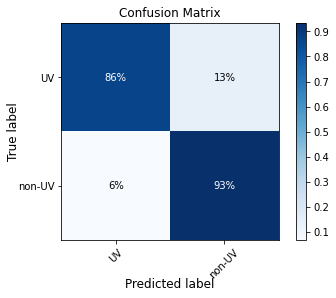

In [125]:
plot_matrix(test_Y ,tPred, [0,1], title='Confusion Matrix',axis_labels=labels)